# Bayesian Statistics Seminar

Copyright 2017 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import thinkbayes2
import thinkplot

## The Price is Right problem

The following function reads data from http://tpirstats.com/

In [2]:
import csv

def ReadData(filename='showcases.2011.csv'):
    """Reads a CSV file of data.

    Args:
      filename: string filename

    Returns: sequence of (price1 price2 bid1 bid2 diff1 diff2) tuples
    """
    fp = open(filename)
    reader = csv.reader(fp)
    res = []

    for t in reader:
        _heading = t[0]
        data = t[1:]
        try:
            data = [int(x) for x in data]
            res.append(data)
        except ValueError:
            pass

    fp.close()
    return list(zip(*res))

The `Player` object encapsulates the information we have about each of the two players.

In [3]:
class Player(object):
    """Represents a player on The Price is Right."""

    def __init__(self, prices, bids, diffs):
        """Construct the Player.

        prices: sequence of prices
        bids: sequence of bids
        diffs: sequence of underness (negative means over)
        """
        self.pdf_price = thinkbayes2.EstimatedPdf(prices)
        self.cdf_diff = thinkbayes2.MakeCdfFromList(diffs)

        mu = 0
        sigma = np.std(diffs)
        self.pdf_error = thinkbayes2.NormalPdf(mu, sigma)

    def ErrorDensity(self, error):
        """Density of the given error in the distribution of error.

        error: how much the bid is under the actual price
        """
        return self.pdf_error.Density(error)

    def PmfPrice(self):
        """Returns a new Pmf of prices.

        A discrete version of the estimated Pdf.
        """
        xs = np.linspace(0, 75000, 101)
        return self.pdf_price.MakePmf(xs=xs)

    def CdfDiff(self):
        """Returns a reference to the Cdf of differences (underness).
        """
        return self.cdf_diff

    def ProbOverbid(self):
        """Returns the probability this player overbids.
        """
        return self.cdf_diff.Prob(-1)

    def ProbWorseThan(self, diff):
        """Probability this player's diff is greater than the given diff.

        diff: how much the oppenent is off by (always positive)
        """
        return 1 - self.cdf_diff.Prob(diff)

    def MakeBeliefs(self, guess):
        """Makes a posterior distribution based on estimated price.

        Sets attributes prior and posterior.

        guess: what the player thinks the showcase is worth        
        """
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self, label='prior')
        self.posterior = self.prior.Copy(label='posterior')
        self.posterior.Update(guess)

    def OptimalBid(self, guess, opponent):
        """Computes the bid that maximizes expected return.
        
        guess: what the player thinks the showcase is worth 
        opponent: Player

        Returns: (optimal bid, expected gain)
        """
        self.MakeBeliefs(guess)
        calc = GainCalculator(self, opponent)
        bids, gains = calc.ExpectedGains()
        gain, bid = max(zip(gains, bids))
        return bid, gain

The following function reads combines data from two years and makes the `Player` objects.

In [4]:
def MakePlayers():
    """Reads data and makes player objects."""
    data = ReadData(filename='showcases.2011.csv')
    data += ReadData(filename='showcases.2012.csv')

    cols = zip(*data)
    price1, price2, bid1, bid2, diff1, diff2 = cols

    player1 = Player(price1, bid1, diff1)
    player2 = Player(price2, bid2, diff2)

    return player1, player2

player1, player2 = MakePlayers()

Here's what the distribution of actual prices looks like for the two showcases.

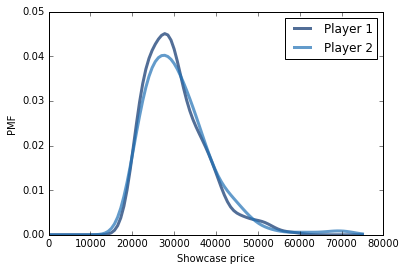

In [5]:
thinkplot.Pdf(player1.PmfPrice(), label='Player 1')
thinkplot.Pdf(player2.PmfPrice(), label='Player 2')
thinkplot.Config(xlabel='Showcase price', ylabel='PMF', loc='upper right')

And here's the CDF of the difference between the actual price and the players bid (positive difference means the actual price was higher; negative difference means the bid was too high).

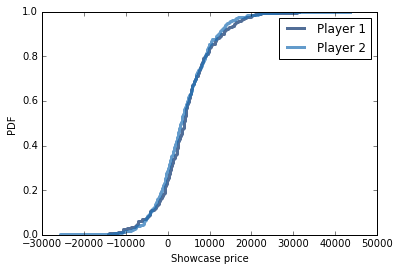

In [6]:
thinkplot.Cdf(player1.CdfDiff(), label='Player 1')
thinkplot.Cdf(player2.CdfDiff(), label='Player 2')
thinkplot.Config(xlabel='Showcase price', ylabel='PDF')

Median differences:

In [7]:
cdf1 = player1.CdfDiff()
cdf2 = player2.CdfDiff()
cdf1.Percentile(50), cdf2.Percentile(50)

(3902, 3136)

We need an error model for the contestants.  Ideally, we would have data on what the contestants thought, rather than what they bid.  Since we don't have that, we have to make some assumptions.

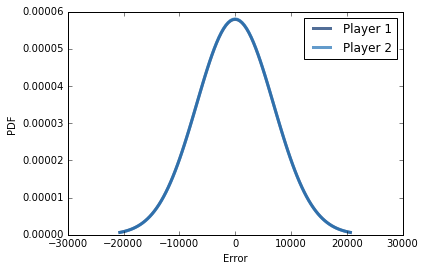

In [8]:
thinkplot.Pdf(player1.pdf_error, label='Player 1')
thinkplot.Pdf(player2.pdf_error, label='Player 2')
thinkplot.Config(xlabel='Error', ylabel='PDF')

**Exercise 1:** What is the probability of overbidding for each player?

In [9]:
# Solution

player1.ProbOverbid(), player2.ProbOverbid()

(0.24600638977635783, 0.29073482428115016)

## The Bayesian part

Here's a class that encapsulates the Bayesian update.

`Likelihood` computes the probability of the player's guess, given the actual price.

In [10]:
class Price(thinkbayes2.Suite):
    """Represents hypotheses about the price of a showcase."""

    def __init__(self, pmf, player, label=None):
        """Constructs the suite.

        pmf: prior distribution of price
        player: Player object
        label: string
        """
        thinkbayes2.Suite.__init__(self, pmf, label=label)
        self.player = player

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: actual price
        data: the contestant's guess
        """
        price = hypo
        guess = data

        error = price - guess
        like = self.player.ErrorDensity(error)

        return like


`MakeBeliefs` uses `PmfPrice` as a prior and updates with a given guess.  Let's suppose Player 1 thinks the first showcase is worth $20000:

In [11]:
player1.MakeBeliefs(20000)
player1.prior.Mean(), player1.posterior.Mean()

(30299.488817891368, 25096.411816206251)

The posterior mean is between the prior mean and the guess.

Now we can plot the prior and posterior:

In [12]:
def PlotBeliefs(player):
    """Plots prior and posterior beliefs.

    player: Player object
    """
    thinkplot.Pdfs([player.prior, player.posterior])
    thinkplot.Config(xlabel='Price ($)', ylabel='PMF')

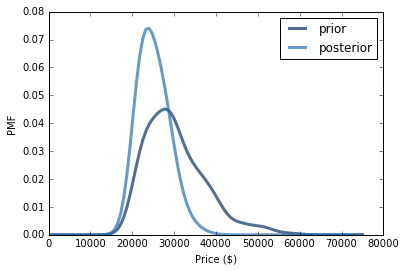

In [13]:
PlotBeliefs(player1)

And here's what it looks like for Player 2, assuming that the initial guess is $40000.

In [14]:
player2.MakeBeliefs(40000)
player2.prior.Mean(), player2.posterior.Mean()

(31034.710418731363, 35641.216869713542)

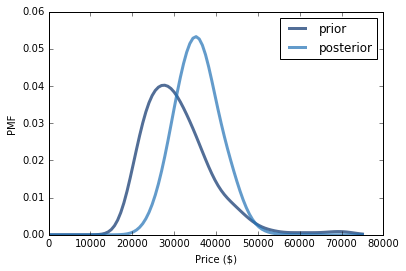

In [15]:
PlotBeliefs(player2)

**Exercise 2:**  Run these two updates again with some different guesses to see how the posterior distribution depends on the guess.

## Decision analysis

Now that we know what the players should believe, let's see what they should do.

`GainCalculator` encapsulates the process for computing expected gain for each potential bid.

Reading from bottom to top:

* `ProbWin` computes the probability of winning, given how much you are off by.

* `Gain` computes how much you'll win, given the actual price.

* `ExpectedGain` computes how much you'll win, averaged over possible prices, given a bid.

* `ExpectedGains` computes the expected gain for all bids.

In [16]:
class GainCalculator(object):
    """Encapsulates computation of expected gain."""

    def __init__(self, player, opponent):
        """Constructs the calculator.

        player: Player
        opponent: Player
        """
        self.player = player
        self.opponent = opponent

    def ExpectedGains(self, low=0, high=75000, n=101):
        """Computes expected gains for a range of bids.

        low: low bid
        high: high bid
        n: number of bids to evaluates

        returns: tuple (sequence of bids, sequence of gains)
    
        """
        bids = np.linspace(low, high, n)

        gains = [self.ExpectedGain(bid) for bid in bids]

        return bids, gains

    def ExpectedGain(self, bid):
        """Computes the expected return of a given bid.

        bid: your bid
        """
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()):
            gain = self.Gain(bid, price)
            total += prob * gain
        return total

    def Gain(self, bid, price):
        """Computes the return of a bid, given the actual price.

        bid: number
        price: actual price
        """
        # if you overbid, you get nothing
        if bid > price:
            return 0

        # otherwise compute the probability of winning
        diff = price - bid
        prob = self.ProbWin(diff)

        # if you are within 250 dollars, you win both showcases
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob

    def ProbWin(self, diff):
        """Computes the probability of winning for a given diff.

        diff: how much your bid was off by
        """
        prob = (self.opponent.ProbOverbid() + 
                self.opponent.ProbWorseThan(diff))
        return prob


I'll instantiate a `GainCalculator` for each player, providing the other player as an opponent.

In [17]:
calc1 = GainCalculator(player1, player2)
calc2 = GainCalculator(player2, player1)

For Player 1, here's the plot of expected gain versus bid.

Player 1 optimal bid (16668.781463564384, 21000.0)


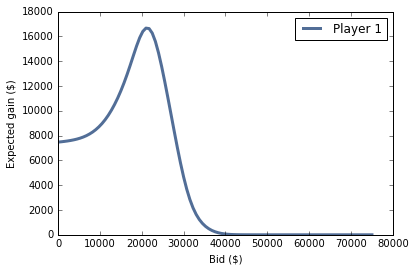

In [18]:
bids, gains = calc1.ExpectedGains()
thinkplot.Plot(bids, gains, label='Player 1')
thinkplot.Config(xlabel='Bid ($)', ylabel='Expected gain ($)')
print('Player 1 optimal bid', max(zip(gains, bids)))

Interestingly, in this case the optimal bid is higher than the guess, which is contrary to the assumption that you would always want to round down to avoid going over.

Player 2 optimal bid (19365.953590885678, 31500.0)


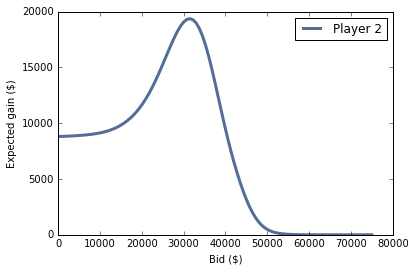

In [19]:
bids, gains = calc2.ExpectedGains()
thinkplot.Plot(bids, gains, label='Player 2')
thinkplot.Config(xlabel='Bid ($)', ylabel='Expected gain ($)')
print('Player 2 optimal bid', max(zip(gains, bids)))

The peak in these curves is pretty steep, which suggests it might be important to get the model right!  One of the assumptions we made is that the contestant guesses are unbiased.

**Exercise 3:**  In `Player.__init__`, change the value of `mu` to add some bias to the contestant guesses.  What effect does this change have on the results?  What if you increase or decrease `sigma`?  

## Optimal bidding

Finally, this function plots the optimal bid for a range of guesses.

In [20]:
def PlotOptimalBid(playerA, playerB):
    """Plots optimal bid vs estimated price.
    """
    low, high = 15000, 60000
    guesses = np.linspace(low, high, 21)

    res = []
    for guess in guesses:
        playerA.MakeBeliefs(guess)
        mean = playerA.posterior.Mean()
        calc = GainCalculator(playerA, playerB)
        bids, gains = calc.ExpectedGains()
        gain, bid = max(zip(gains, bids))
        res.append((guess, mean, gain, bid))

    guesses, means, gains, bids = zip(*res)
    
    thinkplot.PrePlot(num=3)
    thinkplot.Plot([low, high], [low, high], color='gray')
    thinkplot.Plot(guesses, means, label='Posterior mean')
    thinkplot.Plot(guesses, bids, label='Optimal bid')
    thinkplot.Plot(guesses, gains, label='Expected gain')
    thinkplot.Config(xlabel='Guessed price ($)', loc='upper left')

Here are the results for Player 1.

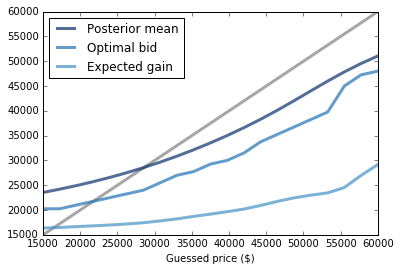

In [21]:
player1, player2 = MakePlayers()
PlotOptimalBid(player1, player2)

Not surprisingly, the optimal bid is always below the posterior mean.

But when the guess is low, the optimal bid sometimes exceeds the guess.

Here's the same analysis for Player 2.

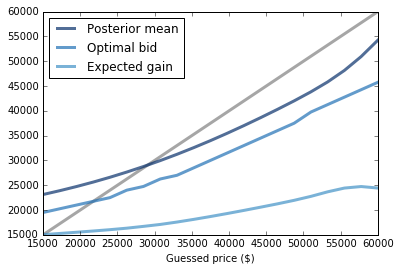

In [22]:
player1, player2 = MakePlayers()
PlotOptimalBid(player2, player1)